In [44]:
import os
import pickle
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR =  r"./"

# Extract Image Feature

In [3]:
 #Load VGG16
model = VGG16()
#restructure
model = Model(inputs = model.inputs, outputs=model.layers[-2].output)
#summarize
model.summary()
#last layer is prediction layer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Run below cell on final testing

In [4]:

# #extract features from images
# features = {}
# directory = BASE_DIR + "Images" #os.path.join(BASE_DIR, "Images")
# for img_name in tqdm(os.listdir(directory)):
#     #Load the image from file
    
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size = (224, 224)) #prefer 256*256
#     #convert image to numpy array
#     image = img_to_array(image)
#     #reshap data for model
    
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) #RGB IMAGE
#     #preprocess model for vgg
#     image = preprocess_input(image)
#     feature = model.predict(image, verbose = 0)
#     #get image ID
#     image_id = img_name.split('.')[0] #basically name of image without extension
#     features[image_id] = feature
    
    
# pickle.dump(features, open(os.path.join(BASE_DIR, "features.pkl"), "wb"))

In [5]:
#load features from pickle
with open(os.path.join(BASE_DIR, "features.pkl"), "rb") as file:
    features = pickle.load(file)

In [6]:
#load the caption data
with open(os.path.join(BASE_DIR, "captions.txt"), "rb") as f:
    next(f)
    captions_doc = f.read().decode('utf-8')
    

In [7]:
#create mapping image to caption
mapping = defaultdict(list)
for line in tqdm(captions_doc.split('\n')):
    #split line by ,
    tokens = line.split(",")
    if len(tokens)<2:
        continue
    image_id, caption = tokens[0], " ".join(tokens[1:])
    image_id = image_id.split(".")[0]
    
    mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
len(mapping)
#8091

8091

# Preprocess the text

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            #One caption at a time
            caption = captions[i]
            
            #preprocess
            caption = caption.lower()
            caption = caption.replace("[^A-Za-z0-9]", "") #remove numbers too
            caption = caption.replace("\s+", " ")
            
            #start and end tags to the caption
            caption = "<start> "  + " ".join(word for word in caption.split() if len(word)>1) + " <end>" #better to set len == 1
            captions[i] = caption
clean(mapping)

In [10]:
len(mapping)

8091

In [11]:
all_captions = []
for key in mapping:
    for words in mapping[key]:
        all_captions.append(words)

In [12]:
len(all_captions)
#about 40455

40455

In [13]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [14]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
vocab_size
#8000

8483

In [16]:
#Get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)

max_length

35

In [17]:
#train test split

image_id = list(mapping.keys())
split = int(len(image_id) * .95)
train = image_id[:split]
test = image_id[split:]

In [18]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n+=1
            captions = mapping[key]
            #process each caption
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                #split the seq into X y pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq =  seq[:i], seq[i]
                    #pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    #Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    
                    #store the sequence
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                    yield [X1, X2], y
                    X1, X2, y = list(), list(), list()
                    n = 0 

# Model Creations

In [19]:
#Encoder Model
#Image feature Model
input1 = Input(shape=(4096, ))
fe1 = Dropout(.4)(input1)
fe2 = Dense(256, activation = 'relu')(fe1)

#Sequence Layers
inputs2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(.4)(se1)
se3 = LSTM(256)(se2)


#Decoder Model

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = "relu")(decoder1)
outputs = Dense(vocab_size, activation = "softmax")(decoder2)

model = Model(inputs = [input1,inputs2], outputs =  outputs)
model.compile(loss = "categorical_crossentropy", optimizer = 'adam')

#plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
epochs = 15
batch_size = 64
steps = len(train) // batch_size
for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs = 1, steps_per_epoch=steps, verbose=1)

120/120 [==============================] - 340s 3s/step - loss: 2.4721


In [24]:
model.save("model.h5")

In [38]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [39]:
#generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = "<start>"
    for i in range(max_length):
        #encode input sequencee
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #padding the sequence
        sequence = pad_sequences([sequence], max_length)
        
        yhat = model.predict([image, sequence], verbose = 0)
        #Convert index with high probability
        yhat = np.argmax(yhat)
        #convert index to word
        word = idx_to_word(yhat, tokenizer)
        #stop id not word
        if not word:
            break
        #append word as input
        in_text += " " + word
        #stop if we reach end tag
        if word == "<end>": break
    return in_text

In [42]:

#Validate 
actual, predicted = list(), list()
for key in tqdm(test):
    #get actual caption
    captions = mapping[key]
    #predict the caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    #append to list
    actual.append(actual_captions)
    predicted.append(y_pred.split())
#Calculate BLEU score 


  0%|          | 0/405 [00:00<?, ?it/s]

NameError: name 'corpus_blue' is not defined

In [43]:
print("BLEU-1 : %f" % corpus_bleu(actual, predicted, weights = (1.0, 0, 0, 0)))
print("BLEU-2 : %f" % corpus_bleu(actual, predicted, weights = (.5, .5, 0, 0)))

BLEU-1 : 0.168999
BLEU-2 : 0.090502


--------------------------Actual-----------------------
<start> black dog and spotted dog are fighting <end>
<start> black dog and tri-colored dog playing with each other on the road <end>
<start> black dog and white dog with brown spots are staring at each other in the street <end>
<start> two dogs of different breeds looking at each other on the road <end>
<start> two dogs on pavement moving toward each other <end>
-------------------------Predicted------------------------------
<start> two dogs play with each other on the sidewalk end end of the grass end end of the other dog end end end end of the other dog end end end of the other dog


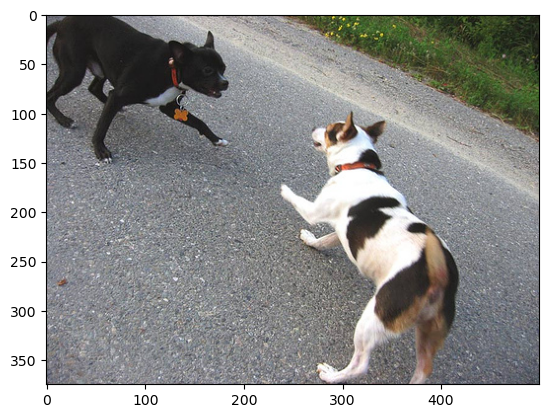

In [48]:
#Visualize the results

#load the image
image_name = "1001773457_577c3a7d70.jpg"

def generate_caption(image_name):
    image_id = image_name.split(".")[0]
    image_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(image_path)

    captions = mapping[image_id]
    print("--------------------------Actual-----------------------")
    for caption in captions:
        print(caption)
    #predict_caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("-------------------------Predicted------------------------------")

    print(y_pred)
    plt.imshow(image)
generate_caption(image_name)



In [51]:
def match_strings(main_string, target_strings, min_match_count):
    matches = []
    
    # Split the main string into individual words
    main_words = main_string.lower().split()
    
    # Iterate over each target string
    for target_string in target_strings:
        # Split the target string into individual words
        target_words = target_string.lower().split()
        
        # Count the number of matches between the main words and target words
        match_count = sum(1 for word in main_words if word in target_words)
        
        # Check if the match count meets the minimum requirement
        if match_count >= min_match_count:
            matches.append(target_string)
    
    # Sort the matches based on the count of matches
    matches.sort(key=lambda x: -sum(1 for word in main_words if word in x.lower().split()))
    
    return matches

# Example usage
main_string = "the black dog fights with blue elephant"
target_strings = ["My name is blue", "I have a blue elephant", "This is cow", "the black dog fights with blue elephant", "my name is blue dog elephant"]  

result = match_strings(main_string, target_strings, min_match_count=2)
print(result)


['the black dog fights with blue elephant', 'my name is blue dog elephant', 'I have a blue elephant']


In [56]:

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91978\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [89]:
import nltk
from nltk.corpus import stopwords

class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end_of_word = False
        self.match_count = 0

class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
        node.is_end_of_word = True

    def search(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                return False
            node = node.children[char]
        return node.is_end_of_word

    def increment_match_count(self, word):
        node = self.root
        for char in word:
            node = node.children[char]
            node.match_count += 1

def match_strings(main_string, target_strings, min_match_count):
#     stop_words = set(stopwords.words('english'))
    stop_words = set()
    trie = Trie()
    matches = []

    # Insert target strings into Trie
    for target_string in target_strings:
        target_words = target_string.lower().split()
        for word in target_words:
            if word not in stop_words:
                trie.insert(word)

    # Split main string into individual words
    main_words = main_string.lower().split()

    # Increment match count in Trie for each main word
    for word in main_words:
        if word not in stop_words:
            trie.increment_match_count(word)

    # Function to count matches using Trie
    def count_matches(words):
        count = 0
        for i in range(len(words) - 1):
            for j in range(i + 1, len(words)):
                word = ' '.join(words[i:j+1])
                word2 = ''.join(words[j-1])
#                 print(word, word2)
                if trie.search(word) or trie.search(word2):
                    count += 1
        count = int((-1 + (1 + 4*count*2)**.5)//2) + 1
        return count

    # Iterate over target strings and count matches
    for target_string in target_strings:
        target_words = target_string.lower().split()
        match_count = count_matches(target_words)
        print(match_count, target_words)
        if match_count >= min_match_count:
            matches.append(target_string)

    # Sort matches based on count of matches
    matches.sort(key=lambda x: -count_matches(x.lower().split()))

    return matches

# Example usage
main_string = "the black dog fights with blue elephant"
target_strings = ["My name is blue", "I have a blue elephant", "This is cow", "the black dog fights with blue elephant"]
stop_words = set(stopwords.words('english'))

result = match_strings(main_string, target_strings, min_match_count=len(main_string.split(" "))*(3/4))
print(result)


4 ['my', 'name', 'is', 'blue']
5 ['i', 'have', 'a', 'blue', 'elephant']
3 ['this', 'is', 'cow']
7 ['the', 'black', 'dog', 'fights', 'with', 'blue', 'elephant']
['the black dog fights with blue elephant']


--------------------------Actual-----------------------
<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>
<start> little girl is sitting in front of large painted rainbow <end>
<start> small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it <end>
<start> there is girl with pigtails sitting in front of rainbow painting <end>
<start> young girl with pigtails painting outside in the grass <end>
-------------------------Predicted------------------------------
<start> two people climb the grass with leaves in the background end end of the rainbow end end of rainbow end end of rainbow end end of rainbow end end of rainbow end end of rainbow


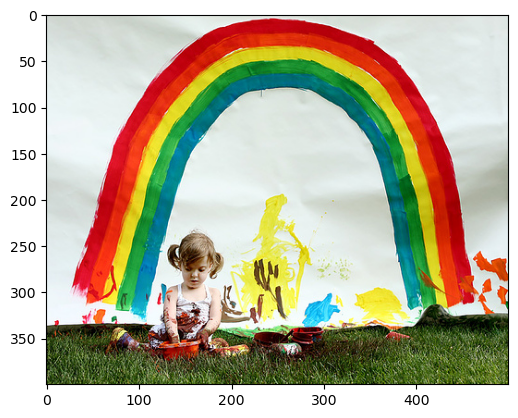

In [91]:
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
model2 = load_model('model.h5')


from tensorflow.keras.models import load_model

# Load the model from the .h5 file
model = load_model('model.h5')

# Use the loaded model for further processing or predictions


image_name = "1002674143_1b742ab4b8.jpg"

def generate_caption(image_name):
    image_id = image_name.split(".")[0]
    image_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(image_path)

    captions = mapping[image_id]
    print("--------------------------Actual-----------------------")
    for caption in captions:
        print(caption)
    #predict_caption
    y_pred = predict_caption(model2, features[image_id], tokenizer, max_length)
    print("-------------------------Predicted------------------------------")

    print(y_pred)
    plt.imshow(image)
generate_caption(image_name)